<a href="https://colab.research.google.com/github/lymoelopez/automated-filipino-fake-news-detector/blob/main/baseline%20model/baselineModelPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline Model Preprocessing

## Import Libraries

In [140]:
import numpy as np
import pandas as pd
# import itertools

# from sklearn.model_selection import train_test_split


# import string

#from sklearn.metrics import precision_recall_fscore_support
# import pickle


## Load Training Dataset




In [141]:
from google.colab import files
import io

In [ ]:
# import Fake News Filipino (FNF) Dateset from local files
FNFdataset = files.upload()

Saving full.csv to full.csv


In [ ]:
# import Back=Translated FNF dataset from local files
backTranslatedFNFdataset = files.upload()

Saving backTranslated.csv to backTranslated.csv


In [142]:
# Store datasets into a Pandas DataFrame
FNFdataFrame = pd.read_csv(io.BytesIO(FNFdataset['full.csv']))
backTranslatedFNFdataFrame = pd.read_csv(io.BytesIO(backTranslatedFNFdataset['backTranslated.csv']))


In [143]:
# Output first 5 records of FNF dataset
FNFdataFrame.head()  

,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


In [144]:
FNFdataFrame.shape

(3206, 2)

In [145]:
# Output first 5 records of Back-Translated FNF dataset
backTranslatedFNFdataFrame.head()  

,label,article
0,0,"Ayon sa TheWrap.com, si Krupa, 35, ay nagsampa..."
1,0,Kilala rin ang mang-aawit sa pagkumpas ng kany...
2,0,"BLANTYRE, Malawi (AP) -- Naglakbay si Madonna ..."
3,0,"Kasama sa programa ang panalangin, bulaklak a..."
4,0,Linisin ang Friendship Department dahil bibis...


In [146]:
backTranslatedFNFdataFrame.shape

(3206, 2)

In [147]:
# Combine FNF and Back-Translated FNF datasets to make the training dataset
trainingDataFrame = FNFdataFrame.append(backTranslatedFNFdataFrame, ignore_index=True)
trainingDataFrame.shape

<ipython-input-147-d724c2b71b26>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trainingDataFrame = FNFdataFrame.append(backTranslatedFNFdataFrame, ignore_index=True)


(6412, 2)

In [148]:
import matplotlib.pyplot as plt

def datasetPieChartDistribution(dataFrame):
  fakeNewsCategory = pd.get_dummies(dataFrame.label)[1]  # 1 = fake, 0 = real
  fakeNewsSize = fakeNewsCategory.sum()
  realNewsSize = len(fakeNewsCategory)- fakeNewsSize

  datasetSize = [fakeNewsSize, realNewsSize]

  plt.pie(datasetSize,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

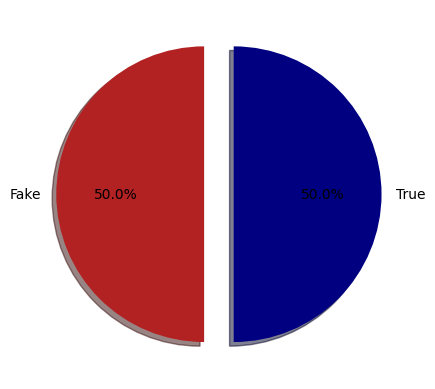

In [149]:
datasetPieChartDistribution(trainingDataFrame)

## Load Test Dataset

In [150]:
# import Translated Philippine Fake News Corpus from local files
TLphFNcorpus = files.upload()

Saving headlinesPhilippineFakeNewsCorpusTL.csv to headlinesPhilippineFakeNewsCorpusTL (1).csv


In [151]:
# Store dataset into a Pandas DataFrame
testingDataFrame = pd.read_csv(io.BytesIO(TLphFNcorpus['headlinesPhilippineFakeNewsCorpusTL.csv']))

In [152]:
testingDataFrame.head()  

,label,headline
0,0,Ika-2 ang PH sa Asia-Pacific sa mga namamatay...
1,0,"Aguirre, hepe ng PCSO, itinanggi ang planong ..."
2,0,Sinabi ni Duterte na mabibigo ang mga kaso la...
3,0,Binalaan ng grupo ang BFAR sa law enforcement...
4,0,Humingi si Solon kay Duterte ng jet ski papun...


In [154]:
testingDataFrame.shape

(22458, 2)

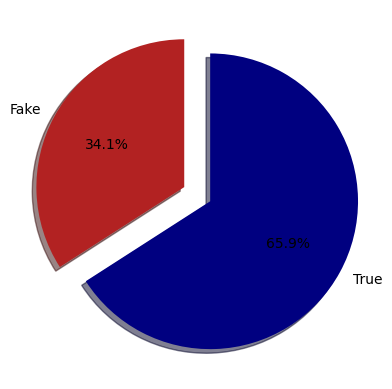

In [155]:
datasetPieChartDistribution(testingDataFrame)

## Preprocessing Layer

### I. Text Cleaning

In [156]:
# punctuation marks, and numbers are retained

import re

def removeCharactersAndLowercase(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)                    # remove URLs
    text = re.sub(r'\S+@\S+', '', text)                                 # remove emails
    text = re.sub(r'#\w+', '', text)                                    # remove hashtags
    text = re.sub('\[.*?\]', '', text)                                  # remove square brackets and their contents
    text = re.sub('\(.*?\)', '', text)                                  # remove parenthesis and their contents
    text = re.sub('<.*?>+', '', text)                                   # remove angle brackets and the characters inside them
    text = re.sub('\n', ' ', text)                                      # remove newline characters
    text = re.sub(r'[^\x00-\x7f]',r'', text)                            # remove non-ASCII characters (e.g. emojis, greek letters, chinise characters
    text = re.sub('\s+',' ',text)                                       # remove extra whitespaces
    text = text.strip()                                                 # remove whitespaces at the beginning and end of the text
    text = text.lower()                                                 # convert to lowercase

    return text

### II. Tokenization (Byte-Pair Encoding)

In [157]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.1 MB/s eta 0:00:00


In [158]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("danjohnvelasco/filipino-sentence-roberta-v1")

In [159]:
def findBPE (text, tokenizer):
  tokenIDs = tokenizer.encode(text)
  BPE = tokenizer.convert_ids_to_tokens(tokenIDs)
  text = " ".join(BPE)
  return text

### Preprocessing Layer Function

In [160]:
def preprocessingLayer(text, tokenizer):

  cleanedText = removeCharactersAndLowercase(text)
  tokenizedText = findBPE(cleanedText, tokenizer)
  return tokenizedText


#### Preprocess Training Dataset

In [161]:
preprocessedTrainingDataFrame = trainingDataFrame.copy()
preprocessedTrainingDataFrame['article'] = preprocessedTrainingDataFrame['article'].apply(preprocessingLayer, args=(tokenizer,))

In [162]:
print(preprocessedTrainingDataFrame)

      label                                            article
0         0  <s> ayon Ġsa Ġthe w rap . com , Ġnaghain Ġng Ġ...
1         0  <s> kilala Ġrin Ġang Ġsinger Ġsa Ġpagk ump as ...
2         0  <s> bl ant y re , Ġmal awi Ġ-- Ġbumiyahe Ġpatu...
3         0  <s> kasama Ġsa Ġprograma Ġang Ġpananalangin , ...
4         0  <s> l inisin Ġang Ġfriendship Ġdepartment Ġdah...
...     ...                                                ...
6407      1  <s> hindi Ġpa Ġnag - e enjoy Ġsi Ġgi ac omo Ġf...
6408      1  <s> sa Ġisang Ġpahayag , Ġpinuna Ġng Ġliberal ...
6409      1  <s> p anoorin Ġitong Ġreaction Ġvideo Ġni Ġg ....
6410      1  <s> para Ġsa Ġmagkapatid Ġna Ġlaging Ġnag - aa...
6411      1  <s> iba Ġtalaga Ġsi Ġvice Ġganda Ġpagdating Ġs...

[6412 rows x 2 columns]


#### Preprocess Testing Dataset

In [167]:
preprocessedTestingDataFrame = testingDataFrame.copy()
preprocessedTestingDataFrame['headline'] = preprocessedTestingDataFrame['headline'].apply(preprocessingLayer, args=(tokenizer,))

In [164]:
print(preprocessedTestingDataFrame)

       label                                           headline
0          0  <s> ika - 2 Ġang Ġph Ġsa Ġas ia - p ac ific Ġs...
1          0  <s> agu irre , Ġhepe Ġng Ġpc so , Ġitinanggi Ġ...
2          0  <s> s inabi Ġni Ġd uterte Ġna Ġmabibigo Ġang Ġ...
3          0  <s> b inalaan Ġng Ġgrupo Ġang Ġb far Ġsa Ġlaw ...
4          0  <s> hum ingi Ġsi Ġsolon Ġkay Ġd uterte Ġng Ġje...
...      ...                                                ...
22453      1  <s> ang Ġphilipp ine Ġelections Ġ2016 Ġay Ġhin...
22454      0  <s> 28 , 000 Ġpamilyang Ġapektado Ġng Ġbaha Ġa...
22455      1  <s> nag alit Ġang Ġsinger Ġna Ġsi Ġj im Ġpar e...
22456      1  <s> si Ġpop e Ġfran cis Ġsinas atan Ġsi Ġpangu...
22457      1  <s> ang Ġunit ed Ġair lines Ġay Ġmag - alok Ġn...

[22458 rows x 2 columns]


## save preprocessed Data

In [165]:
preprocessedTrainingDataFrame.to_csv('train.csv')

In [166]:
preprocessedTestingDataFrame.to_csv('test.csv')

# References

[1] https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/

[2] https://github.com/nabi-hassan/Fake-news-Detection-using-Ensemble-Learning-/blob/master/newnote.ipynb

[3] https://towardsdatascience.com/fake-news-detection-with-machine-learning-using-python-3347d9899ad1

[4] https://jovian.ai/piero-paialunga/notebook

[5] https://youtu.be/5X27excCyXk

[6] https://medium.com/@yashj302/text-cleaning-using-regex-python-f1dded1ac5bd

[7] https://stackoverflow.com/questions/32705962/removing-any-single-letter-on-a-string-in-python?answertab=scoredesc#tab-top

[8] https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python

[9] https://stackoverflow.com/questions/23680976/python-removing-non-latin-characters

